# Optimizing Smart Cache with Bayesian Optimization

The goal of this notebook is to optimize SmartCache using Bayesian Optimization approach.

We're using a sequential model-based optimization approach, that consists of the following loop:
1. Get suggested config from optimizer,
2. Apply suggested config to ``SmartCache``,
3. Execute a fixed workload,
4. Collect the metrics from ``SmartCache``,
5. Register an observation with the optimizer.


In [1]:
# import the required classes and tools
import grpc
import pandas as pd
import logging

from mlos.Logger import create_logger

from mlos.Examples.SmartCache import HitRateMonitor, SmartCache, SmartCacheWorkloadGenerator, SmartCacheWorkloadLauncher
from mlos.Mlos.SDK import MlosExperiment
from mlos.Optimizers.BayesianOptimizerFactory import BayesianOptimizerFactory
from mlos.Optimizers.OptimizationProblem import OptimizationProblem, Objective
from mlos.Spaces import Point, SimpleHypergrid, ContinuousDimension

# The optimizer will be in a remote process via grpc, we pick the port here:
grpc_port = 50051

Launch the optimizer service in a different process:

In [2]:
import subprocess
optimizer_microservice = subprocess.Popen(f"start_optimizer_microservice launch --port {grpc_port}", shell=True)

Now the optimizer service that runs the surrogate model and suggests new points is started in the background.
Next, we instantiate an object that connects to it over grpc using the ``BayesianOptimizerFactory``.

In [3]:
logger = create_logger('Optimizing Smart Cache', logging_level=logging.WARN)
optimizer_service_grpc_channel = grpc.insecure_channel(f'localhost:{grpc_port}')
bayesian_optimizer_factory = BayesianOptimizerFactory(grpc_channel=optimizer_service_grpc_channel, logger=logger)

# The optimization problem

Then we can instantiate our optimization problem. We want to optimize the configuration of the ``SmartCache`` component that contains two implementations: an LRU (least recently used) cache and an MRU cache (most recently used).
The ``SmartCache`` component has two parameters that we can adjust, the type of cache and the cache size. We are using some synthetic workloads for the cache and try to find what the optimum configuration for each workload is.

Here, we measure 'optimum' by the number of cache hits. Another option would be to measure runtime; however, this is a toy example with a trivial workload and there is likely substantial runtime difference.
The parameter search space is declared in ``SmartCache.parameter_search_space``:

In [4]:
SmartCache.parameter_search_space

  Name: smart_cache_config
  Dimensions:
    implementation: {LRU, MRU}

  IF implementation IN {LRU} THEN (
    Name: lru_cache_config
    Dimensions:
      cache_size: {1, 2, ... , 4096}
  )

  IF implementation IN {MRU} THEN (
    Name: mru_cache_config
    Dimensions:
      cache_size: {1, 2, ... , 4096}
  )

The optimization problem is constructed using this parameter space as the input to optimize, and defines a single continuous objective, 'hit_rate' between 0 and 1.

In [5]:
# Optimization Problem
#
optimization_problem = OptimizationProblem(
    parameter_space=SmartCache.parameter_search_space,
    objective_space=SimpleHypergrid(name="objectives", dimensions=[ContinuousDimension(name="hit_rate", min=0, max=1)]),
    objectives=[Objective(name="hit_rate", minimize=False)]
)
# create an optimizer proxy that connects to the remote optimizer via grpc:
# here we could also configure the optimizer
optimizer = bayesian_optimizer_factory.create_remote_optimizer(optimization_problem=optimization_problem)

# Defining workloads
Now we can instantiate our workloads and stand up the MLOS infrastructure, both of which are orchestrated by``SmartCacheWorkloadLauncher``. The MLOS infrastructure consists of the MlosAgent and a communication channel, which are available to both the ``SmartCacheWorkloadGenerator`` and the ``SmartCache``.
The ``SmartCacheWorkloadLauncher`` launches workloads in ``SmartCacheWorkloadGenerator`` in a separate thread, which will actually generate and run the workloads for the smart cache.
The SmartCacheWorkloadLauncher also connects the ``SmartCacheWorkLloadGenerator`` to the optimization problem via a ``MlosAgent`` that will consume the configurations.

In [6]:
workload_launcher = SmartCacheWorkloadLauncher(logger=logger)
mlos_agent = workload_launcher.mlos_agent

We set up the agent to consume configurations for the ``SmartCacheWorkloadGenerator``, and we configure the workload to be sequential keys from a range from 0 to 2048.

In [7]:
mlos_agent.set_configuration(
    component_type=SmartCacheWorkloadGenerator,
    new_config_values=Point(
        workload_type='cyclical_key_from_range',
        cyclical_key_from_range_config=Point(
            min=0,
            range_width=2048
        )
    )
)

# Launching the experiment (measurement)
Now we build the experiment, which collects hit-rate statistics from the ``SmartCacheWorkloadGenerator`` via the ``HitRateMonitor``. This architecture reflects the native architecture for the C++ interface in which communication is done via shared memory between MLOS and the worker.

In [8]:
hit_rate_monitor = HitRateMonitor()
smart_cache_experiment = MlosExperiment(
    smart_component_types=[SmartCache],
    telemetry_aggregators=[hit_rate_monitor]
)
mlos_agent.start_experiment(smart_cache_experiment)

# Performing the optimization
Now that we have all the pieces in place, we can iterate our main optimization loop.
Our workload will run in the same process as this notebook, but in a separate thread, which we block on.
In a real example, the workload might run completely independent of our optimization procedure.

We run the optimization for 20 iterations, in each of which we obtain a new configuration from the optimizer (that interfaces the remote optimizer service).
The configuration is passed to ``SmartCacheWorkloadGenerator`` via the ``MlosAgent``, after which we start a blocking workload for 0.2 seconds.
Then, the hit-rate (our objective) is read from the ``HitRateMonitor`` and the suggested configuration together with the resulting hit-rate are passed to the optimizer.

In [9]:
num_iterations = 100
data = []
for i in range(num_iterations):
    # suggest runs a 'cheap' search on the surrogate model to find a good candidate configuration
    new_config_values = optimizer.suggest()
    # set_configuration communicates the proposed configuration to the SmartCache
    mlos_agent.set_configuration(component_type=SmartCache, new_config_values=new_config_values)
    hit_rate_monitor.reset()
    # start_workload will actually run the worker, here for 0.2 seconds
    workload_launcher.start_workload(duration_s=0.2, block=True)
    # obtain hit-rate as quality measure for configuration
    hit_rate = hit_rate_monitor.get_hit_rate()
    objectives_df = pd.DataFrame({'hit_rate': [hit_rate]})
    # pass configuration and observed hit-rate to the optimizer to update the surrogate model
    features_df = new_config_values.to_dataframe()
    optimizer.register(features_df, objectives_df)
    print(f"[{i+1}/{num_iterations}] current_config: {new_config_values.to_json()}, hit_rate: {hit_rate:.3f}")

[1/100] current_config: {"implementation": "LRU", "lru_cache_config.cache_size": 265}, hit_rate: 0.000
[2/100] current_config: {"implementation": "LRU", "lru_cache_config.cache_size": 2013}, hit_rate: 0.000
[3/100] current_config: {"implementation": "LRU", "lru_cache_config.cache_size": 630}, hit_rate: 0.000
[4/100] current_config: {"implementation": "MRU", "mru_cache_config.cache_size": 1884}, hit_rate: 0.862
[5/100] current_config: {"implementation": "LRU", "lru_cache_config.cache_size": 2041}, hit_rate: 0.000
[6/100] current_config: {"implementation": "LRU", "lru_cache_config.cache_size": 3969}, hit_rate: 0.951
[7/100] current_config: {"implementation": "MRU", "mru_cache_config.cache_size": 286}, hit_rate: 0.127
[8/100] current_config: {"implementation": "MRU", "mru_cache_config.cache_size": 3323}, hit_rate: 0.953
[9/100] current_config: {"implementation": "MRU", "mru_cache_config.cache_size": 1656}, hit_rate: 0.760
[10/100] current_config: {"implementation": "LRU", "lru_cache_confi

# Analyzing results

For a cyclical workload with 2048 keys, we assume that a MRU cache with a size of at least 2048 will perform best, and get 100% hits once the cache is filled.
Now lets see the suggestions and results from the current experiment.

In [10]:
# some pandas wrangling
features, targets = optimizer.get_all_observations()
data = pd.concat([features, targets], axis=1)
data

,implementation,lru_cache_config.cache_size,mru_cache_config.cache_size,hit_rate
0,LRU,265.0,NaN,2.911210e-10
1,LRU,2013.0,NaN,4.093330e-10
2,LRU,630.0,NaN,4.675080e-10
3,MRU,NaN,1884.0,8.619243e-01
4,LRU,2041.0,NaN,3.941660e-10
...,...,...,...,...
95,LRU,1976.0,NaN,4.048580e-10
96,LRU,1425.0,NaN,4.732610e-10
97,MRU,NaN,1024.0,4.645777e-01
98,MRU,NaN,2903.0,9.574132e-01


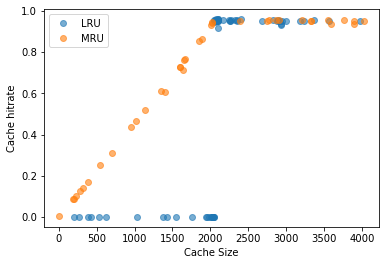

In [11]:
# group by implementation, then plot
lru_data, mru_data = data.groupby('implementation')

import matplotlib.pyplot as plt
line_lru = lru_data[1].plot(x='lru_cache_config.cache_size', y='hit_rate', label='LRU', marker='o', linestyle='none', alpha=.6)
mru_data[1].plot(x='mru_cache_config.cache_size', y='hit_rate', label='MRU', marker='o', linestyle='none', alpha=.6, ax=plt.gca())
plt.ylabel("Cache hitrate")
plt.xlabel("Cache Size")
plt.legend()

We can see that if the cache size is over 2048 keys, it means everything can fit into the cache and the strategy does not matter.
However, for smaller cache sizes, the MRU strategy has an obvious advantage over the LRU strategy.

# Going Further

1) Log how the optimum evolves over time. How many iterations are needed?

2) Can you adjust options in the Optimizer to improve convergence (see the BayesianOptimization notebook for suggestions).

3) Choose a different workload in the ``SmartCacheWorkloadGenerator``. How do the workloads change the optimum strategy?

# Clean up
We need to stop all processes & separate threads after running the experiments:

In [12]:
# Clean up
#
mlos_agent.stop_experiment(smart_cache_experiment)
mlos_agent.stop_all()

# Stop the optimizer service
import signal
optimizer_microservice.send_signal(signal.SIGTERM)